In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import dlib
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from imageio import imread
from skimage.transform import resize
from scipy.spatial import distance
from keras.models import load_model

%matplotlib inline

Using TensorFlow backend.


In [3]:
def prewhiten(x):
    mean = np.mean(x)
    std = np.std(x)
    std_adj = np.maximum(std, 1.0/np.sqrt(x.size))
    y = np.multiply(np.subtract(x, mean), 1/std_adj)
    return y

In [4]:
def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [33]:
def load_and_align_images(image_filepaths, margin):
    detector = dlib.get_frontal_face_detector()

    aligned_images = []
    for image_filepath in image_filepaths:
        try:
            img = imread(image_filepath)
            faces = detector(img, 1)

            skipMulti = False
            if (not skipMulti and len(faces) > 0) or len(faces) == 1:
                bb = max(faces, key=lambda rect: rect.width() * rect.height())

            cropped = img[bb.top()-margin//2:bb.bottom()+margin//2,
                          bb.left()-margin//2:bb.right()+margin//2, :]
            aligned = resize(cropped, (image_size, image_size), mode='reflect')
            prewhitened = prewhiten(aligned)
            aligned_images.append(prewhitened)
        except:
            print('except!',image_filepath)
            
    return np.array(aligned_images)

In [34]:
def calc_dist(img_name0, img_name1):
    return distance.euclidean(data[img_name0]['emb'], data[img_name1]['emb'])

def calc_dist_plot(img_name0, img_name1):
    print(calc_dist(img_name0, img_name1))
    plt.subplot(1, 2, 1)
    plt.imshow(imread(data[img_name0]['image_filepath']))
    plt.subplot(1, 2, 2)
    plt.imshow(imread(data[img_name1]['image_filepath']))

In [71]:
image_dir_basepath = '/Users/osuzuki/web_apps/deep_learning/team14/facenet/member_test/member_images/'
image_size = 160

model_path = '../model/facenet-keras/model/facenet_keras.h5'
model = load_model(model_path)

/Users/osuzuki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [73]:
data = {}
names = ['takemoto', 'taniai']
max_num_img = 100
margin = 10
batch_size = 20

for name in names:
    image_dirpath = os.path.abspath(image_dir_basepath + 'images_{}/'.format(name))
    image_filepaths = [os.path.join(image_dirpath, f) for f in os.listdir(image_dirpath)][:max_num_img]
    image_filepaths = [path for path in image_filepaths if ".DS_Store" not in path]
    aligned_images = load_and_align_images(image_filepaths, margin)
    embs = []
    for start in range(0, max_num_img, batch_size):
        embs.append(model.predict_on_batch(aligned_images[start:start+batch_size]))    
    embs = l2_normalize(np.concatenate(embs, axis=0))
    for i in range(len(image_filepaths)):
        data['{}{}'.format(name, i)] = {'image_filepath' : image_filepaths[i],
                                        'emb' : embs[i]}

0.43414950370788574


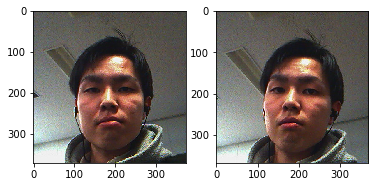

In [74]:
calc_dist_plot('takemoto0', 'takemoto1')

0.30660736560821533


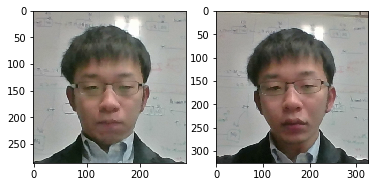

In [75]:
calc_dist_plot('taniai0', 'taniai1')

1.015618920326233


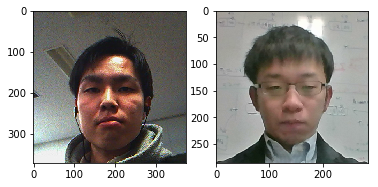

In [76]:
calc_dist_plot('takemoto0', 'taniai0')

1.0790257453918457


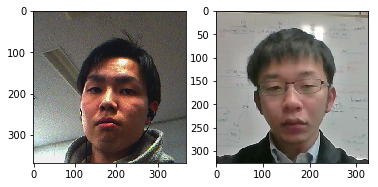

In [77]:
calc_dist_plot('takemoto1', 'taniai1')

1.128902554512024


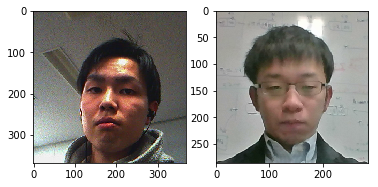

In [78]:
calc_dist_plot('takemoto1', 'taniai0')